In [3]:
from amalearn.reward import GaussianReward, RewardBase
from amalearn.agent import AgentBase
from amalearn.environment import EnvironmentBase
import numpy as np
from math import *
import matplotlib.pyplot as plt
import scipy.stats as stats
import gym
import random

* Reward class: 
    * The following Reward class inherits from RewardBase class and includes value and probability of the reward.
* NArmedBanditEnvironment class:
    * The select_action_epsilon method get a value p randomly between 0 to 1 and if it is less than the epsilon then it returns the best action otherwise it selects a random action.  
    * The update_epsilon_selected_arm method updates the resulted Q value of the selected arm by adding alpha * (Ri - Q_value) which is a multiplier of the error.
    * The select_action_UCB method checks if the arm is selected at least once or not. if the arm is not selected it counts that arms value as infinity and if the arm is selected at least once it counts Q_value_i + c_level * sqrt(np.log(np.sum(T))/T_i) as the value and returns index of the arm with maximum value.
    * The update_UCB_selected_arm method updates the selected arm to (Q*T+R)/(T+1) and increaments T of the arm by 1.
* Agent_epsilonGreedy class:
    * This class has three variable one for epsilon, one for the alpha value and one array of calculated Q_values.
    * The take_action method selcts an arm with select_action_epsilon method of the environment and recieves the reward and updates the selected arm's Q_value with update_epsilon_selected_arm method.
* Agent_UCB class:
    * This class has a variable for c_level and two array one for Q_values and one for keeping track of jow many times (T) an arm is selected.
    * The take_action method selcts an arm with select_action_UCB method of the environment and recieves the reward and updates the selected arm's Q_value and T with update_UCB_selected_arm method.

In [4]:
class Reward(RewardBase):
    def __init__(self, value, p):
        super(Reward, self).__init__()
        self.value = value
        self.p = p
        
    
    def get_reward(self):
        return np.random.choice(a = self.value,p = self.p)
    
    def update(self, Ri):
        return

class NArmedBanditEnvironment(EnvironmentBase):
    def __init__(self, reward_mean, reward_var, arm_count, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(arm_count)
        super(NArmedBanditEnvironment, self).__init__(action_space, state_space, id, container)
        self.arm_count = arm_count
        self.rewards = [Reward(reward_mean[i], reward_var[i]) for i in range(arm_count)]
        self.time = 0
        
    def sample_all_rewards(self):
        return
    
    def select_action_epsilon(self, epsilon, Q_value):
        p = random.random()
        if p< epsilon:
            return np.argmax(Q_value)
        else:
            return np.random.choice(self.arm_count)
    
    def update_epsilon_selected_arm(self, index_selected_arm, Q_value, Ri, alpha):
        Q_value[index_selected_arm] = Q_value[index_selected_arm] + alpha * (Ri - Q_value[index_selected_arm])
        return Q_value
     
    def update_UCB_selected_arm(self, index_selected_arm, c_level, T, Q_value, Ri):
        Q_value[index_selected_arm] = Q_value[index_selected_arm] * T[index_selected_arm] + Ri
        T[index_selected_arm] = T[index_selected_arm] + 1 
        Q_value[index_selected_arm] = Q_value[index_selected_arm]/ T[index_selected_arm]
        return Q_value, T
        
    def select_action_UCB(self, c_level, T, Q_value):
        ucb = []
        for i in range(len(T)):
            if T[i] !=0 :
                ucb.append(Q_value[i] + c_level * sqrt(np.log(np.sum(T))/T[i]))
            else:
                ucb.append(np.inf)
        return np.argmax(ucb)
        
    def calculate_reward(self, action):
        return self.rewards[action].get_reward()

    def terminated(self):
        return 

    def observe(self):
        return 

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        return

    def reset(self):
        return

    def render(self, mode='human'):
        #print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))
        return 

    def close(self):
        return
    
class Agent_epsilonGreedy(AgentBase):
    def __init__(self,epsilon, environment, alpha, id):
        self.epsilon = epsilon
        self.Q_value = np.zeros(environment.arm_count)
        super(Agent_epsilonGreedy, self).__init__(id, environment)
        self.alpha = alpha
        
    def take_action(self) -> (object, float, bool, object):
        index_selected_arm = self.environment.select_action_epsilon(self.epsilon, self.Q_value)
        obs, Ri, d, i = self.environment.step(index_selected_arm)
        #print(Ri, index_selected_arm )
        self.Q_value = self.environment.update_epsilon_selected_arm(index_selected_arm, self.Q_value, Ri, self.alpha)
        #print(obs, r, d, i)
        self.environment.render()
        return obs, Ri, d, i
    
class Agent_UCB(AgentBase):
    def __init__(self, environment, id, c_level):
        self.c_level = c_level
        self.T = np.ones(environment.arm_count)  * 1000
        super(Agent_UCB, self).__init__(id, environment)
        self.Q_value = np.zeros(environment.arm_count)
        
    def take_action(self) -> (object, float, bool, object):
        index_selected_arm = self.environment.select_action_UCB(self.c_level, self.T, self.Q_value)
        obs, Ri, d, i = self.environment.step(index_selected_arm)
        self.Q_value, self.T =self.environment.update_UCB_selected_arm(index_selected_arm, self.c_level, self.T, self.Q_value, Ri)
        #print(obs, r, d, i)
        self.environment.render()
        return obs, Ri, d, i

Result of UCB  method:

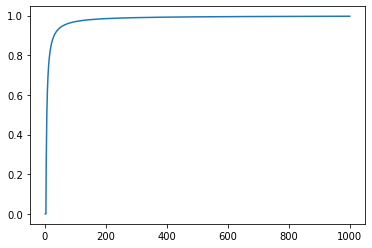

In [75]:
reward_value = [[45,-10],[40,-20],[35,-30],[30,-40],[25,-50],[0,-400]]
reward_p = [[0.02,0.98],[0.157,0.843],[0.498,0.502],[0.84,0.16],[0.975,0.025],[0.00000001,0.99999999]]
env = NArmedBanditEnvironment(reward_value, reward_p, 6, 1)
agent = Agent_UCB(env, '2', 0.1)
agent2 = Agent_epsilonGreedy(0.1, env, 0.1, '1')
action_selected_UCB = []
optimal_count = 0
R_ucb = [0]
for step in range(1000):
    _,r,_,_ = agent.take_action()
    if np.argmax(agent.Q_value) == 4:
        optimal_count = optimal_count + 1
    action_selected_UCB.append(optimal_count/(step+1))
    R_ucb.append((R_ucb[step-1]*step + r)/(step+1))
plt.plot([i+1 for i in range(1000)], action_selected_UCB)
plt.show()

Result of epsilon greedy method:

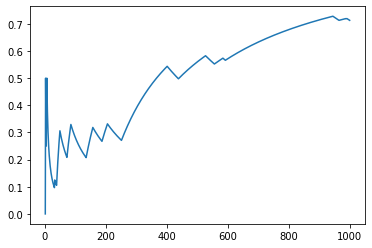

In [76]:
env = NArmedBanditEnvironment(reward_value, reward_p, 6, 1)
action_selected_epsilon = []
optimal_count = 0
R_epsilon = [0]
for step in range(1000):
    _,r,_,_ = agent2.take_action()
    if np.argmax(agent2.Q_value) == 4:
        optimal_count = optimal_count + 1
    action_selected_epsilon.append(optimal_count/(step+1))
    R_epsilon.append((R_epsilon[step-1]*step + r)/(step+1))
plt.plot([i+1 for i in range(1000)], action_selected_epsilon)
plt.show()

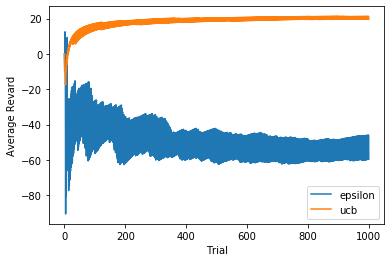

In [81]:
plt.plot([i for i in range(1001)], R_epsilon, label = "epsilon")
plt.plot([i for i in range(1001)], R_ucb, label="ucb")
plt.xlabel("Trial")
plt.ylabel("Average Revard")
plt.legend()
plt.show()